In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import math

## Question 1

In [4]:
np.random.seed(21)
sample_size = 100
average_l1 = []
average_l2 = []
std_1 = []
std_2 = []
dimensions = [2**i for i in range(0, 11)]

for dim in dimensions:
  l1_distances = []
  l2_distances = []
  sample = np.random.rand(sample_size, dim)
  for i in range(sample_size):
    dp1 = sample[i]
    for j in range(i + 1, sample_size):
      dp2 = sample[j]
      l1_distance = sum([abs(dp1[k] - dp2[k]) for k in range(0, dim)])
      l1_distances.append(l1_distance)
      l2_distance = sum([(dp1[k] - dp2[k])**2 for k in range(0, dim)])
      l2_distances.append(l2_distance)
  average_l1.append(np.mean(l1_distances))
  std_1.append(np.std(l1_distances))
  average_l2.append(np.mean(l2_distances))
  std_2.append(np.std(l2_distances))

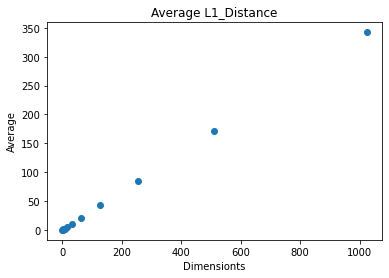

In [5]:
plt.scatter(dimensions, average_l1)
plt.title('Average L1_Distance')
plt.xlabel('Dimensionts')
plt.ylabel('Average')
plt.show()

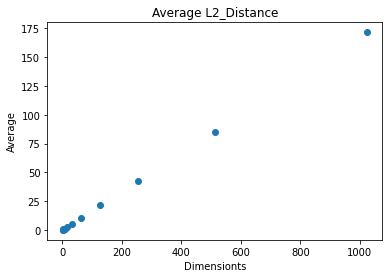

In [6]:
plt.scatter(dimensions, average_l2)
plt.title('Average L2_Distance')
plt.xlabel('Dimensionts')
plt.ylabel('Average')
plt.show()

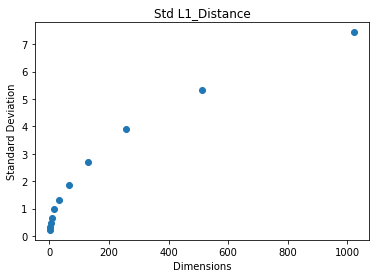

In [7]:
plt.scatter(dimensions, std_1)
plt.title('Std L1_Distance')
plt.xlabel('Dimensions')
plt.ylabel('Standard Deviation')
plt.show()

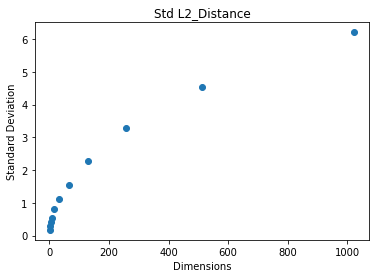

In [8]:
plt.scatter(dimensions, std_2)
plt.title('Std L2_Distance')
plt.xlabel('Dimensions')
plt.ylabel('Standard Deviation')
plt.show()

## Question2

In [9]:
# (a)

def load_data(fake_f, real_f):
    np.random.seed(21)  # Set Seed

    # Initialize lists
    x_dset = []
    y_dset = []

    # Read fake news file
    fake = open(fake_f, 'r')
    for line in fake:
        x_dset.append(line)
        y_dset.append('fake')
    fake.close()

    # Read real news file
    real = open(real_f, 'r')
    for line in real:
        x_dset.append(line)
        y_dset.append('real')
    real.close()

    # Vectorization
    vectorizer = CountVectorizer()
    x_dset = vectorizer.fit_transform(x_dset)

    # Split Datasets
    x_train, x_left, y_train, y_left = train_test_split(x_dset, y_dset, test_size=0.3)
    x_val, x_test, y_val, y_test = train_test_split(x_left, y_left, test_size=0.5)
    return {'x_train': x_train, 'x_val': x_val, 'x_test': x_test,
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
            'feature_name': vectorizer.get_feature_names_out()}

In [10]:
def get_accuracy(prediction, actual):
    correct = 0
    for i in range(len(prediction)):
      if prediction[i] == actual[i]:
        correct += 1
    return round(correct / len(prediction), 5)

In [11]:
# (b)

def get_accuracy(prediction: list, actual: list) -> float:
    correct = 0
    for i in range(len(prediction)):

        # Check Equivalence
        if prediction[i] == actual[i]:
            correct += 1

    return round(correct / len(prediction), 5)


def select_model(data: dict):

    # Initialize Hyper-parameters
    max_depths = [2 ** i for i in range(1, 6)]
    criterions = ['gini', 'entropy', 'log_loss']
    record = [[], [], []]

    # Training and Record Accuracy
    for max_depth in max_depths:
        i = 0
        for criterion in criterions:
            new_model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
            new_model.fit(data['x_train'], data['y_train'])
            val_accuracy = get_accuracy(new_model.predict(data['x_val']), data['y_val'])

            record[i].append(val_accuracy)
            print(
                f"The validation accuracy for model max_depth {max_depth} and criterion {criterion} is {val_accuracy}")
            i = i + 1

    # Select the model with the highest accuracy
    highest_accuracy = max(max(record[i]) for i in range(0, 3))
    highest_model = None
    for i in range(0, 3):
        for j in range(0, 5):
            if record[i][j] == highest_accuracy:
                highest_model = (max_depths[j], criterions[i])
                break
        if highest_model is not None:
            break
    print(
        f"""The model that reaches the highest accuracy has max_depth {highest_model[0]} and criterion {highest_model[1]}
            The corresponding accuracy is {highest_accuracy}""")

    # Find the best model and get test_accuracy
    final_model = DecisionTreeClassifier(max_depth=highest_model[0], criterion=highest_model[1])
    final_model.fit(data['x_train'], data['y_train'])
    test_accuracy = get_accuracy(final_model.predict(data['x_test']), data['y_test'])
    print(f"Our best model has test accuracy {test_accuracy}")

    # Plot
    plt.plot(max_depths, record[0], c='r', label='gini')
    plt.scatter(max_depths, record[0], c='r', label='gini')
    plt.plot(max_depths, record[1], c='g', label='entropy')
    plt.scatter(max_depths, record[1], c='g', label='entropy')
    plt.plot(max_depths, record[2], c='b', label='log_loss')
    plt.scatter(max_depths, record[2], c='b', label='log_loss')
    plt.title('val accuracy vs. max_depth')
    plt.xlabel('max_depths')
    plt.ylabel('val accuracy')
    plt.legend()
    plt.show()

    return final_model

In [12]:
# (c)(d)

def entropy(events_num: list) -> float:
    all_en = []
    for event_num in events_num:
        event_prob = event_num / (sum(events_num))
        single = event_prob * math.log(event_prob, 2)
        all_en.append(single)
    return -sum(all_en)


def compute_information_gain(left: list, right: list) -> float:
    # Compute H(Y)
    h_y = entropy([left[0] + right[0], left[1] + right[1]])

    # Compute H(Y | X)
    h_left = entropy(left)
    left_prob = sum(left) / sum(left + right)
    h_right = entropy(right)
    right_prob = sum(right) / sum(left + right)
    h_y_under_x = left_prob * h_left + right_prob * h_right

    return round(h_y - h_y_under_x, 5)


def get_split_information_gain(x_data, y_data, word_index, decision_bound: float) -> float:
    x_data_array = x_data.toarray()
    left_fake, left_real, right_fake, right_real = 0, 0, 0, 0
    for i in range(len(x_data_array)):
        dp = x_data_array[i]
        label = y_data[i]
        decision = (dp[word_index] <= decision_bound)
        if decision:
            if label == 'fake':
                left_fake += 1
            else:
                left_real += 1
        else:
            if label == 'fake':
                right_fake += 1
            else:
                right_real += 1
    return compute_information_gain([left_fake, left_real], [right_fake, right_real])


The validation accuracy for model max_depth 2 and criterion gini is 0.67551
The validation accuracy for model max_depth 2 and criterion entropy is 0.67551
The validation accuracy for model max_depth 2 and criterion log_loss is 0.67551
The validation accuracy for model max_depth 4 and criterion gini is 0.70612
The validation accuracy for model max_depth 4 and criterion entropy is 0.70612
The validation accuracy for model max_depth 4 and criterion log_loss is 0.70612
The validation accuracy for model max_depth 8 and criterion gini is 0.7102
The validation accuracy for model max_depth 8 and criterion entropy is 0.71224
The validation accuracy for model max_depth 8 and criterion log_loss is 0.71429
The validation accuracy for model max_depth 16 and criterion gini is 0.72041
The validation accuracy for model max_depth 16 and criterion entropy is 0.72449
The validation accuracy for model max_depth 16 and criterion log_loss is 0.72857
The validation accuracy for model max_depth 32 and criteri

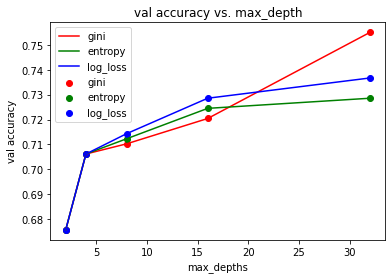

Information Gain for the topmost split: 0.05014
Some other words: 
Information Gain for the split based on word trump is 0.03569
Information Gain for the split based on word and is 0.01077
Information Gain for the split based on word 2016 is 0.00087
Information Gain for the split based on word fake is 1e-05
Information Gain for the split based on word news is 0.00522


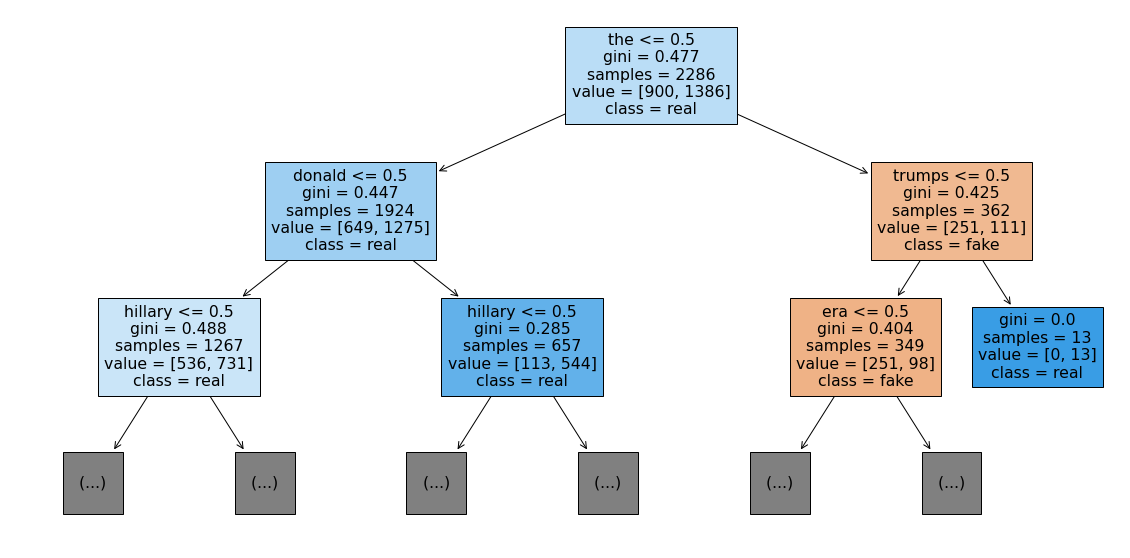

In [15]:
if __name__ == '__main__':
    data = load_data('clean_fake.txt', 'clean_real.txt')
    model = select_model(data)
    features = data['feature_name']
    fig = plt.figure(figsize=(20, 10))
    tree.plot_tree(model, filled=True, max_depth=2, class_names=model.classes_, feature_names=features)
    print(f"Information Gain for the topmost split: {compute_information_gain([649, 1275], [251, 111])}")
    print("===" * 25)
    print("===" * 25)
    print("Some other words: ")
    words = ["trump", "and", "2016", "fake", "news"]
    for word in words:
        word_index = np.where(features == word)
        print(f"Information Gain for the split based on word {word} is "
              f"{get_split_information_gain(data['x_train'], data['y_train'], word_index, 0.5)}")